#Lista 2  - Processamento Digital de Imagens

In [ ]:
#Bibliotecas utilizadas
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd


1) - Equalize the color image colorful-red-blue.png in two ways: one by equalizing
each individual channel of the RGB space and another by equalizing the I channel
of the HSI space (implement the conversion code). Compare the results and indicate which approach is most appropriate.

Para  solucionar o proposto exercício  foram testadas duas técnicas de equalização em imagens coloridas, durante o processo foi utilizado o mesmo código de cálculo do histograma feito na primeira lista, sendo este capaz de percorrer a imagem pixel a pixel e quantificar a existência de cada quantidade de tom de cor (0 a 255), obtendo a distribuição de cores presente na imagem.

Para a primeira abordagem foi feita a equalização no formato RGB,  aplicou-se o processo de equalização global de forma independente em cada um dos três canais da imagem, esses canais então foram normalizados para se obter a função de distribuição acumulada (CDF). A partir dessa função, se faz possivel o mapeamento que transforma os níveis de intensidade  originais em novos valores, obtendo assim um canal equalizado. A imagem final é formada a partir da reconstrução da imagem utilizando os canais equalizados.

A segunda abordagem consistiu na equalização utilizando o espaço de cores HSI, para executar essa tarefa inicialmente se construiu a função de conversão de cores RGB para HSI, os três canais de cores dessa imagem convertida foram separados e a equalização foi aplicada diretamente no canal de intensidade (I). A imagem resultante é obtida por meio da reconstrução utilizando os três canais e a conversão da imagem do espaço HSI para RGB.


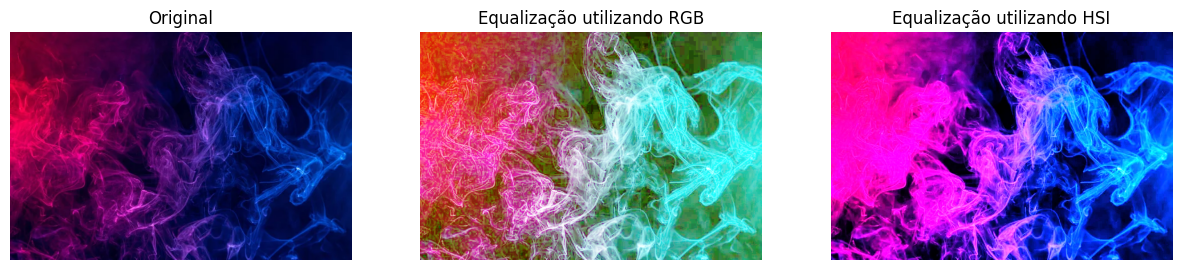

In [ ]:
#Calcula o histograma da imagem:
def calcula_histograma (image):
  histogram = [0] *256
  for i in range (image.shape[0]):
    for j in range (image.shape[1]):
      intensidade = int(image[i,j])
      histogram [intensidade] = histogram[intensidade] + 1
  return histogram

#Faz a equalização global:
def equalizacao_global (img):
  altura, largura = img.shape
  N = altura*largura
  is_float = img.dtype == np.float32 or img.dtype == np.float64
  #trabalha com valores do tipo float, aplicando uma nomralizacao
  if is_float:
        img_int = np.clip((img * 255), 0, 255).astype(np.uint8)
  else:
        img_int = img

  hist = calcula_histograma(img_int)
  Norm = [x / N for x in hist]

  cdf=[]
  acumulado = 0

  for pixel in Norm:
    acumulado += pixel
    cdf.append(acumulado)

  mapeia_intensi = [round(255*c) for c in cdf]
  img_equalizada = np.zeros_like(img, dtype=np.uint8)
  for i in range (altura):
    for j in range(largura):
      img_equalizada[i,j] = mapeia_intensi[img_int[i,j]]

  return img_equalizada

def equaliza_com_cores (img):
    #separando a imagem nos três canais de cores
    img_red   = img[:, :, 0]
    img_green = img[:, :, 1]
    img_blue  = img[:, :, 2]

    #Equalizando os canais da imagem usando a funcao de equalizacao global
    img_red_equalizada   = equalizacao_global(img_red)
    img_green_equalizada = equalizacao_global(img_green)
    img_blue_equalizada  = equalizacao_global(img_blue)

    #Unindo os três canais para reconstruir a imagem
    img_equalizada_rgb = np.stack((img_red_equalizada, img_green_equalizada, img_blue_equalizada), axis=2)

    return img_equalizada_rgb


def transforma_rgb_hsv(img):

    img_rgb = img.astype(float) / 255.0
    #Extracao dos canais de cores de forma individual
    img_red   = img_rgb [:, :, 0]
    img_green = img_rgb [:, :, 1]
    img_blue  = img_rgb[:, :, 2]


    # Inicialização das matrizes
    altura, largura = img.shape[0], img.shape[1]
    H = np.zeros((altura, largura))
    S = np.zeros((altura, largura))
    I = np.zeros((altura, largura))
    img_hsv = np.zeros((altura, largura, 3))
    epsilon = 1e-10  # Para evitar divisões por zero

    for linha in range(altura):
        for coluna in range(largura):
            R = img_red[linha, coluna]
            G = img_green[linha, coluna]
            B = img_blue[linha, coluna]

            num = 0.5 * ((R - G) + (R - B))
            den = np.sqrt((R - G)**2 + (R - B) * (G - B)) + 1e-10 + epsilon
            theta = np.arccos(num / den)


            if B <= G:
                H[linha, coluna] = theta
            else:
                H[linha, coluna] = 2 * np.pi - theta

            I[linha, coluna] = (R + G + B) / 3
            S[linha, coluna] = 1 - (3 * min(R, G, B)) / (R + G + B + epsilon)

    img_hsi = np.stack((H, S, I), axis=-1)
    return img_hsi

def transforma_HSI_to_RGB(img):
    #Separa a imagem recebida nos três canais de cores
    img_H = img[:, :, 0]
    img_S = img[:, :, 1]
    img_I = img[:, :, 2]

    #Criando as os canais que receberam as cores RGB:
    img_R = np.zeros_like(img_H)
    img_G = np.zeros_like(img_H)
    img_B = np.zeros_like(img_H)

    #Criando a imagem final no formato RGB:
    img_RGB = np.zeros_like(img)
    limx,limy = img_H.shape
    for i in range (limx):
      for j in range (limy):
        #Converte os valores presente no canal H de radianos para graus
        graus = np.degrees (img_H[i,j])

        #Calculos dos valores presentes nos canais R,G,B considerando os graus
        if graus >= 0 and graus < 120:
          img_R[i,j] = img_I[i,j]* (1+ (img_S[i,j]*np.cos(np.radians(graus))/np.cos(np.radians(60-graus))))
          img_B[i,j] = img_I[i,j]*(1 - img_S[i,j])
          img_G[i,j]= 3*img_I[i,j] - (img_R[i,j] + img_B[i,j])

        elif graus >= 240 and graus <360:
          h = graus - 240
          img_G[i,j]= img_I[i,j]*(1 - img_S[i,j])
          img_B[i,j] = img_I[i,j]* (1+ (img_S[i,j]*np.cos(np.radians(h))/np.cos(np.radians(60-h))))
          img_R [i,j] = 3 * img_I[i,j]-(img_G[i,j] +img_B[i,j])

        elif graus >= 120 and graus <240:
          h = graus - 120
          img_G[i,j] = img_I[i,j] * (1+ (img_S[i,j]*np.cos(np.radians(h))/np.cos(np.radians(60-h))))
          img_R[i,j] = img_I[i,j] * (1 - img_S[i,j])
          img_B[i,j] = 3 * img_I[i,j] - (img_G[i,j] + img_R[i,j])

        else:
            img_R[i,j] = img_I[i,j]
            img_G[i,j] = img_I[i,j]
            img_B[i,j] = img_I[i,j]


    #Construindo a imagem convertida a partir dos canais calculados
    img_RGB[:,:,0] = img_R
    img_RGB[:,:,1] = img_G
    img_RGB[:,:,2] = img_B

    return img_RGB


def equaliza_com_HSI (img):
    #Obtem uma conversao utilizando a funcao criada para a transformacao rgb - hsi
    img_hsv = transforma_rgb_hsv(img)
    #Separa os tres canais de cores do espaco HSI
    H,S,I = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2]
    #Aplica a equalizacao somente no canal I
    I_equalizada = equalizacao_global(I)
    #Cria uma nova imagem vazia para receber o resultado do processo.
    img_equalizada_hsv = np.zeros_like(img_hsv)
    #Copia os canais de forma individual para dentro da nova imagem e gera uma resultante
    img_equalizada_hsv[:,:,0] = H
    img_equalizada_hsv[:,:,1] = S
    img_equalizada_hsv[:,:,2] = I_equalizada
    #Executa a conversao do espaco HSI para o espaco RGB para devolver um resultado final
    img_equalizada_hsv = transforma_HSI_to_RGB(img_equalizada_hsv)
    #Percorre os valores da imagem resultante e ajusta para um interval de 0 a 255
    img_equalizada_hsv = np.clip(img_equalizada_hsv, 0, 255).astype(np.uint8)
    return img_equalizada_hsv

#Execucao dos testes da funcao implementada
img1 = cv2.imread('colorful-red-blue.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
#Aplica cada uma das tecnicas de equalizacao para a obtencao de resultados
img_equalized_rgb = equaliza_com_cores(img1)
img_equalized_hsi = equaliza_com_HSI(img1)
#Processo de exibicao dos resultados
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(img1)
plt.axis('off')
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(img_equalized_rgb)
plt.axis('off')
plt.title('Equalização utilizando RGB')
plt.subplot(1,3,3)
plt.imshow(img_equalized_hsi)
plt.axis('off')
plt.title('Equalização utilizando HSI')
plt.show()

Foi observado durante a resolução
do exercício que a imagem resultante do método de equalização utilizando cores RGB possui uma distorção no que condiz às cores, alterando totalmente o padrão original da imagem, além de aumentar a quantidade de detalhes presentes na imagem apresentando um certo aspecto desbotado, isso ocorre devido ao fato de que a proporção entre os três canais de cores é modificada durante a aplicação do processo de equalização. Já na abordagem usando cores HSI, temos que as cores foram preservadas sendo somente realçadas pelo processo, devido ao fato de equalizar somente o brilho presente na imagem deixando os demais canais inalterados. Logo temos que o método utilizando o espaço de cores HSI se mostrou mais indicado para o processo de equalização solicitado.


2) - Propose and implement a solution to automatically change the color of oranges to green in the image oranges.jpg. Show the result and explain the solution.

O processo para manipulação de cores das laranjas desenvolvido se baseia no uso de cores no espaço HSI, devido ao fato de permitir trabalhar os canais de forma independentes entre si. Para manipular as cores na imagem, foi alterado somente o canal de cores Hue (matiz), que representa a cor pura em si. Com isso, temos que foi criada uma máscara para conter somente os pixels presentes nos limiares de tom laranja (limite inferior e superior próximo a essa tonalidade). Com essa máscara, se faz possível encontrar somente os pixels a serem modificados na imagem.

Para se executar a alteração dos pixels laranjas presentes na imagem para tons de verde, temos que o valor original do canal H é substituído pelo valor que representa a cor verde (aproximadamente 120 graus no círculo de cores). Como somente esse canal é usado na busca e na alteração, temos que conceitualmente todos os pixels laranjas são alterados na imagem, independentemente da intensidade ou da saturação preservando assim a textura e o volume existentes.

Após a alteração das cores dos pixels no espaço HSI, a imagem resultante então é convertida para o espaço de cores RGB, entregando assim um resultado final.

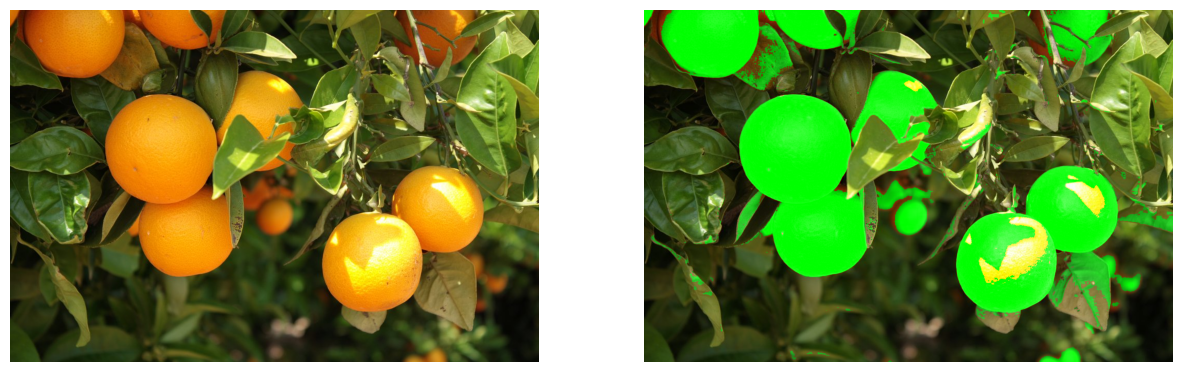

In [ ]:
def transforma_rgb_hsi(img):
    #Normaliza para melhorar o desempenho no processo de transformacoes
    #feitas na imagem.
    img_rgb = img.astype(float) / 255.0
    #Separando os tres canais de cores da imagem rgb
    img_red   = img_rgb [:, :, 0]
    img_green = img_rgb [:, :, 1]
    img_blue  = img_rgb[:, :, 2]


    # Inicialização das matrizes
    altura, largura = img.shape[0], img.shape[1]
    H = np.zeros((altura, largura))
    S = np.zeros((altura, largura))
    I = np.zeros((altura, largura))
    img_hsv = np.zeros((altura, largura, 3))

    #Adicionei para evitar que ocorra divisao por zero durante a conversao
    epsilon = 1e-10

    for linha in range(altura):
        for coluna in range(largura):
            #Acessa os vetores com o valor dos pixels em cada canal e utiliza
            #para se executar os calculos de conversao.
            R = img_red[linha, coluna]
            G = img_green[linha, coluna]
            B = img_blue[linha, coluna]
            #Calcula o valor de theta para analise do valor da cor a ser convertida.
            num = 0.5 * ((R - G) + (R - B))
            den = np.sqrt((R - G)**2 + (R - B) * (G - B)) + 1e-10 + epsilon
            theta = np.arccos(num / den)

            #aplica as condicoes de transformacao descrita nos slides.
            if B <= G:
                H[linha, coluna] = theta
            else:
                H[linha, coluna] = 2 * np.pi - theta

            I[linha, coluna] = (R + G + B) / 3
            S[linha, coluna] = 1 - (3 * min(R, G, B)) / (R + G + B + epsilon)

    #Reconstroi a imagem com os valores obtidos para cada um dos canais no espaco HSI.
    img_hsi = np.stack((H, S, I), axis=-1)
    return img_hsi

def transforma_HSI_to_RGB(img):
    #Separa a imagem recebida nos três canais de cores
    img_H = img[:, :, 0]
    img_S = img[:, :, 1]
    img_I = img[:, :, 2]

    #Criando as os canais que receberam as cores RGB:
    img_R = np.zeros_like(img_H)
    img_G = np.zeros_like(img_H)
    img_B = np.zeros_like(img_H)

    #Criando a imagem final no formato RGB:
    img_RGB = np.zeros_like(img)
    limx,limy = img_H.shape
    for i in range (limx):
      for j in range (limy):
        #Converte os valores presente no canal H de radianos para graus
        graus = np.degrees (img_H[i,j])

        #Calculos dos valores presentes nos canais R,G,B considerando os graus
        if graus >= 0 and graus < 120:
          img_R[i,j] = img_I[i,j]* (1+ (img_S[i,j]*np.cos(np.radians(graus))/np.cos(np.radians(60-graus))))
          img_B[i,j] = img_I[i,j]*(1 - img_S[i,j])
          img_G[i,j]= 3*img_I[i,j] - (img_R[i,j] + img_B[i,j])

        elif graus >= 240 and graus <360:
          h = graus - 240
          img_G[i,j]= img_I[i,j]*(1 - img_S[i,j])
          img_B[i,j] = img_I[i,j]* (1+ (img_S[i,j]*np.cos(np.radians(h))/np.cos(np.radians(60-h))))
          img_R [i,j] = 3 * img_I[i,j]-(img_G[i,j] +img_B[i,j])

        elif graus >= 120 and graus <240:
          h = graus - 120
          img_G[i,j] = img_I[i,j] * (1+ (img_S[i,j]*np.cos(np.radians(h))/np.cos(np.radians(60-h))))
          img_R[i,j] = img_I[i,j] * (1 - img_S[i,j])
          img_B[i,j] = 3 * img_I[i,j] - (img_G[i,j] + img_R[i,j])

        else:
            img_R[i,j] = img_I[i,j]
            img_G[i,j] = img_I[i,j]
            img_B[i,j] = img_I[i,j]


    #Construindo a imagem convertida a partir dos canais calculados
    img_RGB[:,:,0] = img_R
    img_RGB[:,:,1] = img_G
    img_RGB[:,:,2] = img_B

    return img_RGB


def altera_cores_laranjas (img):

  #Faz a conversao das cores para o espaco hsi
  img_hsv = transforma_rgb_hsi(img)

  #Criando os tres canais de cores HSI
  altura, largura = img.shape[0], img.shape[1]
  H = np.zeros((altura, largura))
  S = np.zeros((altura, largura))
  I = np.zeros((altura, largura))

  #Separando os canais de cores
  H,S,I = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2]

  #Definir os extremos dos limiares das cores as serem substituidas
  #Considerei que é possivel encontrar as laranjas utilizando o intervalo de cores
  #no espaço HSI.
  limiar_superior_H = np.deg2rad(55)  # amarelo
  limiar_inferior_H = np.deg2rad(15)  # vermelho claros
  #ajuste de saturcaoe e intensidade
  limiar_superior_S = 1.0
  limiar_inferior_S = 0.45
  limiar_superior_I = 1.0
  limiar_inferior_I = 0.25

  # Criando uma máscara usando esses espaços de cores:
  mask_h = (H >= limiar_inferior_H) & (H <= limiar_superior_H)
  mask_s = (S >= limiar_inferior_S) & (S <= limiar_superior_S)
  mask_i = (I >= limiar_inferior_I) & (I <= limiar_superior_I)
  mask_hsi = mask_h & mask_s & mask_i

  #Trocando as cores dos pixels da mascara para verde:
  H[mask_hsi] = np.deg2rad(120)

  #Cria a nova imagem com as cores trocadas
  img_hsi_editada = np.stack((H, S, I), axis=2)
  # Converte de volta para RGB
  img_rgb_editada = transforma_HSI_to_RGB(img_hsi_editada)
  img_rgb_editada = np.clip(img_rgb_editada * 255.0, 0, 255).astype(np.uint8)
  return img_rgb_editada

#Executando teste do metodo de resolucao proposto
img2 = cv2.imread('oranges.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img_modificada = altera_cores_laranjas(img2)
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(img2)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_modificada)
plt.axis('off')

plt.show()

O resultado obtido para o método proposto desmonstra que o mesmo se mostrou funcional, sendo capaz de alterar a maioria dos pixels laranjas presentes na imagem, mas em alguns pontos onde existem lugares com maior luminosidade,  o método proposto não foi capaz de preencher os pixels devido ao fato das cores se aproximarem mais de tons amarelos ou brancos, se encontrando fora do limiar de tons de laranjas.

Em algumas outras situações, temos a presença de pontos de ruídos principalmente em regiões onde as folhas se aproximam muito de tons alaranjados. Por se tratar de um método mais simples temos que o resultado de uma maneira geral se mostrou aceitável dentro de sua limitações, podendo ser um pouco mais aperfeiçoado a partir do uso de técnicas de segmentação mais robustas, capazes de considerar a forma e os pixels da vizinhança.

3) - Use morphological processing to count the
number of sticks in Fig8.02(a).jpg and the number of pixels in the body (light part) of each stick. Use some technique to binarize the image. Show the results and explain the proposed solution.

A solução proposta resolve o problema de contagem de palitos por meio do processo sequencial: binarização, processamento morfológico de fechamento, busca por componentes conectados (algoritmo de rotulação) e, por fim, filtragem para contagem da quantidade de palitos presentes na imagem. Para segmentar a imagem, inicialmente se utilizou uma limiarização global para separar os palitos do fundo. A imagem obtida no processo anterior então é submetida a um processamento morfológico de fechamento (Closing), que envolve a aplicação de uma dilatação seguida por uma erosão. Isso foi utilizado para preencher buracos e eliminar ruídos, tornando os objetos mais sólidos e coesos. A partir da imagem mais limpa, foi utilizado um algoritmo de rotulação de componentes conectados para identificar cada palito como um objeto individual, atribuindo um rótulo único e calculando a área em pixels de cada um.

Para entregar um resultado final os palitos podem ser considerados como um grande agrupamento de pixels no resultado obtido para os componentes conectados.  Logo foi aplicada uma filtragem por tamanho para descartar quaisquer artefatos pequenos que não sejam palitos, resultando na contagem final e, de forma paralela, na contagem da quantidade de pixels que compõem cada palito na imagem.


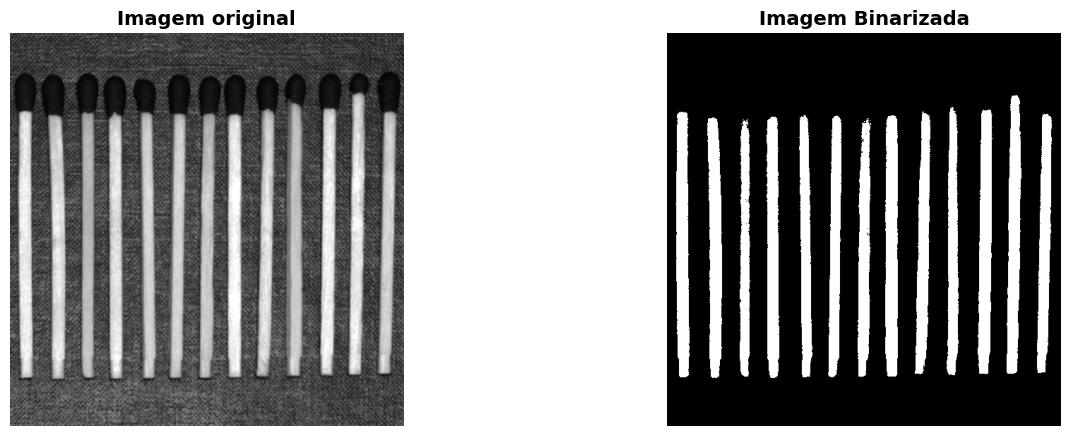

In [ ]:

def insert_padding(img, mask):
    #Extração dos valores da dimensão da imagem e a dimensão da máscara utilizada.
    img_alt, img_larg= img.shape
    alt_mask, larg_mask = mask.shape
    #Calculo da dimensão dos paddings utilizados
    pad_alt = alt_mask // 2
    pad_larg = larg_mask // 2
    #Calculo das dimensões da nova imagem considerando o complemento dos pixels considerando o padding:
    new_alt = img_alt + 2 * pad_alt
    new_larg = img_larg + 2 * pad_larg
    #Inicilizando uma nova imagem vazia utilizada para receber a nova imagem com o padding inserido:
    img_aux = np.zeros ((new_alt, new_larg))
    #Copia a imagem original para o centro da nova imagem, o resto se mantem zero
    img_aux[pad_alt : pad_alt + img_alt, pad_larg : pad_larg + img_larg] = img
    return img_aux

def executa_binarizacao(img, t):
  #Extraindo as dimensoes da imagem e criando uma nova imagem vazia para receber o resultado.
  altura, largura = img.shape
  img_binarizada = np.zeros_like(img)
  #Percorre a imagem aplicando o processo de binarizacao
  for i in range (altura):
    for j in range (largura):
      #se o pixel for maior que o limiar t o valor assumido e preto
      if img[i,j] >= t :
        img_binarizada [i,j] = 255
      #se for menor assume o novo pixel e branco
      else:
        img_binarizada [i,j] = 0

  return img_binarizada

def cria_dilatacao (img, kernel):
  #Encontra as dimensoes da imagem e do kernel
  altura, largura = img.shape
  altura_kernel, largura_kernel = kernel.shape
  #Cria a nova imagem com o resultado do processo de dilatacao
  img_dilatacao = np.zeros_like(img)
  img_padding = insert_padding(img, kernel)

  #Pecorrendo a imgem para aplicar o processo de dilatacao
  for i in range (altura):
    for j in range (largura):
      regiao_analise = img_padding[i : i + altura_kernel, j : j + largura_kernel]
      if np.any(regiao_analise[kernel == 255]):
        img_dilatacao[i, j] = 255

  return img_dilatacao


def cria_erosao (img, kernel):
  #Encontra as dimensoes da imagem e do kernel
  altura, largura = img.shape
  altura_kernel, largura_kernel = kernel.shape
  #Cria a nova imagem com o resultado do processo de erosao
  img_erosao = np.zeros_like(img)
  img_padding = insert_padding(img, kernel)

  #Pecorrendo a imagem para aplicar  o processo de erosao
  for i in range (altura):
    for j in range (largura):

      regiao_analise = img_padding[i : i + altura_kernel, j : j + largura_kernel]

      if np.all(regiao_analise[kernel == 255] == 255):

        img_erosao[i, j] = 255

  return img_erosao



def busca_elemento_conectados(img_binaria_0_1):

  # Inicializacao das variaveis utilizadas
    altura, largura = img_binaria_0_1.shape
    pixels_mapeados = np.zeros_like(img_binaria_0_1, dtype=bool)
    labels = np.zeros_like(img_binaria_0_1, dtype=int)
    label_atual = 1
    dados_elementos = []

  #Percorre a imagem pixel a pixel
    for i in range(altura):
        for j in range(largura):
          # Verifica se esta em um pixel contido em um novo objeto
            if img_binaria_0_1[i, j] == 1 and not pixels_mapeados[i, j]:

                pilha = [(i, j)]
                pixels_encontrados = 0

                # Realiza busca em profundidade para marcar todos os pixels conectados
                while pilha:
                    curr_i, curr_j = pilha.pop()
                # Ignora pixels fora da imagem
                    if curr_i < 0 or curr_i >= altura or curr_j < 0 or curr_j >= largura:
                        continue
                # Ignora pixels já mapeados ou que não pertencem ao objeto
                    if pixels_mapeados[curr_i, curr_j] or img_binaria_0_1[curr_i, curr_j] == 0:
                        continue
                # Adiciona o novo pixel a encontrado a lista de ja detectados
                    pixels_mapeados[curr_i, curr_j] = True
                    labels[curr_i, curr_j] = label_atual
                    pixels_encontrados += 1

                # Analisa vizinhanca considerando que seja 8 pixel vizinhos
                    for di in [-1, 0, 1]:
                        for dj in [-1, 0, 1]:
                            if di == 0 and dj == 0:
                                continue
                            pilha.append((curr_i + di, curr_j + dj))

                # Armazena os dados do componente encontrado
                if pixels_encontrados > 0:
                    dados_elementos.append({'label': label_atual, 'pixels': pixels_encontrados})
                    label_atual += 1


    return labels, dados_elementos


def contas_palitos (img):
  #Faz o pre_processamento da imagem:
  #Aplica  as tecnica de binarização para tonar a imagem binzarizada
  #Aplica a dilatação para eliminar ruidos da imagem binarizada
  #Aplicada a erosão para dexar os palitos com dimensões similares ao da imagem original.

  img_bin = executa_binarizacao(img, 175)
  kernel = np.ones((3, 3), dtype=np.uint8) * 255
  img_dilatacao = cria_dilatacao(img_bin, kernel)
  img_erosao = cria_erosao(img_dilatacao, kernel)

  # Converte imagem processada para valores binarios (0 e 1)
  img_erosao = (img_erosao == 255).astype(int)
  # Busca os componentes conectados
  labels,dados_elementos = busca_elemento_conectados(img_erosao)
  #Filtra objetos conectados, como pequenos ruidos existentes
  min_pixels = 50
  palitos_validos = [comp for comp in dados_elementos if comp['pixels'] >= min_pixels]
  # Conta o numero de palitos
  num_palitos = len(palitos_validos)

  plt.imshow(labels, cmap='nipy_spectral')
  plt.title("Componentes Conectados", fontsize=14, fontweight='bold')
  plt.axis('off')
  plt.tight_layout(pad=3)
  plt.show()

  return num_palitos,dados_elementos



img3 = cv2.imread('Fig8.02(a).jpg', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(img3, cmap = 'gray')
plt.title('Imagem original', fontsize=14, fontweight='bold')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(executa_binarizacao(img3,175), cmap='gray')
plt.title('Imagem Binarizada', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout(pad=3)
plt.show()






Como pode ser observado a imagem binarizada obtida possui pequenas falhas como pequenos pontos escuros no interior dos palitos, para melhorar a qualidade da imagem binarizada a mesma foi submetida a processo morfológico de closing  como indicado nas próximas imagens.

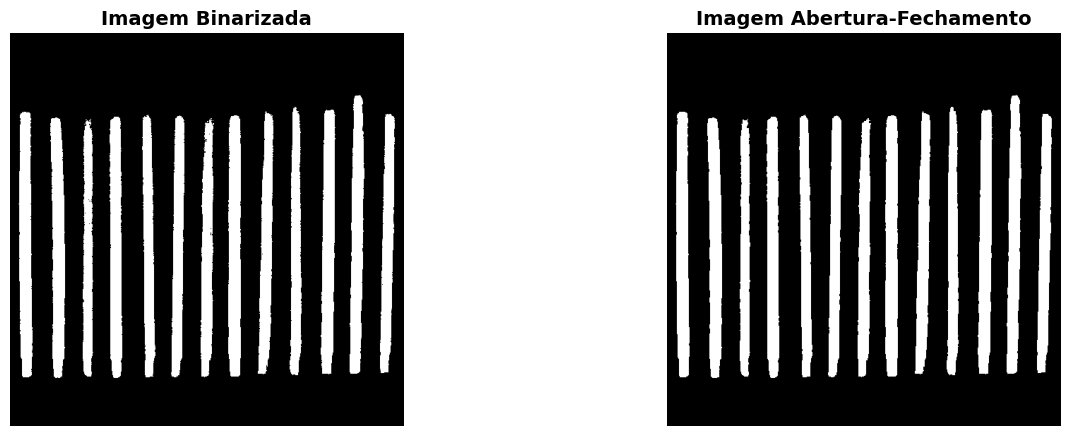

In [ ]:
kernel = np.ones((3, 3), dtype=np.uint8) * 255
img_dilatacao = cria_dilatacao(executa_binarizacao(img3,175), kernel)
img_open_close = cria_erosao(img_dilatacao, kernel)
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(executa_binarizacao(img3,175), cmap = 'gray')
plt.title('Imagem Binarizada', fontsize=14, fontweight='bold')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_open_close, cmap='gray')
plt.title('Imagem Abertura-Fechamento', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout(pad=3)
plt.show()

Como desmostrado nas imagens anteriores com o procedimento de Closing (dilatação seguida de erosão) conseguiu melhorar ainda mais a qualidade da binarização obtida, se analisarmos o terceiro palito vindo da esquerda para a direita, temos que o pontos escuros em seu interior foram completamente removidos da imagem.

A aplicação dessa operação foi necessária devido a solicitação de se conhecer a quantidade de pixels de cada palito, logo se mostrou interessante eliminar os pixels escuros pouco perceptíveis no interior das partes claras. Essa imagem limpa então foi passada para função implementa para se encontrar elementos conectados obtendo o resultado a seguir.


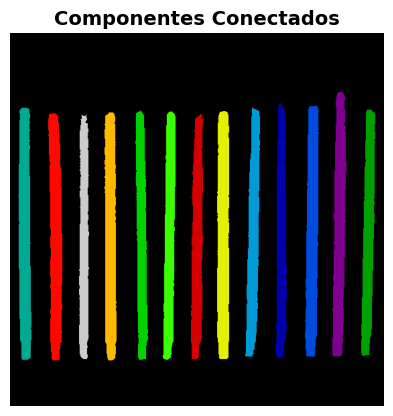

In [ ]:
quantide_palitos,dados_palitos = contas_palitos(img3)


Temos que a técnica implementada para se encontrar objetos conectados se mostrou funcional, obtendo 13 formas diferentes na imagem. O resultado estatístico para  a quantidade de pixels presentes em cada palito é descrito a seguir.

In [ ]:
print(f"Quantidade de palitos na imagem: {quantide_palitos}")
for info in dados_palitos:
  print(f"  Palito {info['label']}: {info['pixels']} pixels")

Quantidade de palitos na imagem: 13
  Palito 1: 6122 pixels
  Palito 2: 4970 pixels
  Palito 3: 6128 pixels
  Palito 4: 5428 pixels
  Palito 5: 6125 pixels
  Palito 6: 5355 pixels
  Palito 7: 5022 pixels
  Palito 8: 5227 pixels
  Palito 9: 6221 pixels
  Palito 10: 5796 pixels
  Palito 11: 6068 pixels
  Palito 12: 5252 pixels
  Palito 13: 4519 pixels


 4)- Place a red border on each rice in the rice.tif image that does not touch the image boundaries. Explain your solution and show your result.

Para se executar o procedimento de encontrar os grãos de arroz na imagem, temos que inicialmente foi feito o processo de binarização por meio do uso de limiarização adaptativa local. Esse método foi escolhido devido ao desequilíbrio que existe entre a luminosidade na imagem, método o qual apresentou um melhor resultado pelo fato de a imagem ser dividida em subamostras mais equilibradas para ser limiarizada.

Para se encontrar a localização dos grãos de arroz na imagem binarizada, utilizou-se a função de rotulação de componentes conectados implementada na questão 3.  Na imagem obtida nesse ponto,  já temos a localização de todos os pixels contidos entre os elementos conectados para detectar somente os grãos de arroz que não toquem as bordas e desenhar um contorno em tom vermelho, o problema pode ser resolvido obtendo-se as coordenadas de todos os pixels contidos nas bordas da imagem e ignorando todos os elementos conectados que possuam ao menos um pixel presente na lista de pixels das bordas.

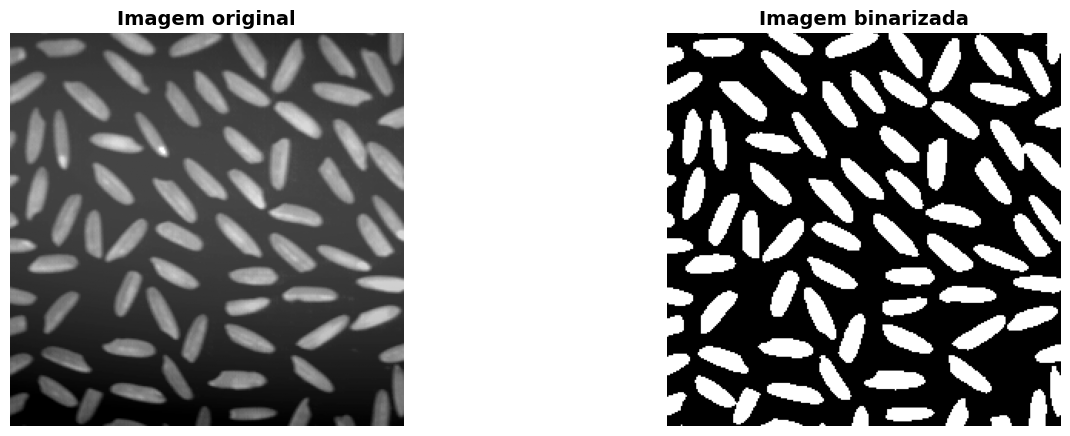

In [ ]:
def insert_padding(img, mask):
    #Extração dos valores da dimensão da imagem e a dimensão da máscara utilizada.
    img_alt, img_larg= img.shape
    alt_mask, larg_mask = mask.shape
    #Calculo da dimensão dos paddings utilizados
    pad_alt = alt_mask // 2
    pad_larg = larg_mask // 2
    #Calculo das dimensões da nova imagem considerando o complemento dos pixels considerando o padding:
    new_alt = img_alt + 2 * pad_alt
    new_larg = img_larg + 2 * pad_larg
    #Inicilizando uma nova imagem vazia utilizada para receber a nova imagem com o padding inserido:
    img_aux = np.zeros ((new_alt, new_larg))
    #Criando a imagem com padding:
    #Como a imagem já se encontra em tons de cinza a conta considera somente a existencia de um canal.
    img_aux = np.zeros((new_alt, new_larg), dtype=img.dtype)

    #INsere o padding a partir da replicação das bordas da imagens :
    #Copia a imagem original para o centro:
    img_aux[pad_alt:pad_alt + img_alt, pad_larg:pad_larg + img_larg] = img
    #copia as bordas da imagem :
    img_aux[0:pad_alt, pad_larg:pad_larg + img_larg] = img[0, :]
    img_aux[new_alt - pad_alt:, pad_larg:pad_larg + img_larg] = img[-1, :]
    img_aux[:, 0:pad_larg] = img_aux[:, pad_larg:pad_larg + 1]
    img_aux[:, new_larg - pad_larg:] = img_aux[:, new_larg - pad_larg - 1:new_larg - pad_larg]

    return img_aux

def binariza_imagem_estasticas_locais (img, janela, a, b):
  if janela % 2 == 0:
    print("Janela informada invalida, insira um tamanho impar.")
  altura, largura = img.shape
  img_binarizada = np.zeros_like(img)

  #Inserido padding na imagem:
  img_padding = insert_padding(img, np.ones((janela, janela)))

  #Percorre a imagem e binariza de acordo com as estaticas locais:
  for i in range (altura):
    for j in range (largura):
      regiao_analise = img_padding[i : i + janela, j : j + janela]
      media = np.mean(regiao_analise)
      desvio_padrao = np.std(regiao_analise)

      if img[i,j] > (b * media) and img[i,j] > (a * desvio_padrao):

        img_binarizada[i, j] = 255

  return img_binarizada

def cria_erosao (img, kernel):
  #Encontra as dimensoes da imagem e do kernel
  altura, largura = img.shape
  altura_kernel, largura_kernel = kernel.shape
  #Cria a nova imagem com o resultado do processo de erosao
  img_erosao = np.zeros_like(img)
  img_padding = insert_padding(img, kernel)

  #Pecorrendo a imagem para aplicar  o processo de erosao
  for i in range (altura):
    for j in range (largura):

      regiao_analise = img_padding[i : i + altura_kernel, j : j + largura_kernel]

      if np.all(regiao_analise[kernel == 1] == 1):

        img_erosao[i, j] = 1

  return img_erosao

#Implementa uma funcao para encontrar elementos conectados em uma imagem
def busca_elemento_conectados(img_binaria_0_1):

  #extrai propriedades da imagem original
    altura, largura = img_binaria_0_1.shape
    pixels_mapeados = np.zeros_like(img_binaria_0_1, dtype=bool)
    labels = np.zeros_like(img_binaria_0_1, dtype=int)
    label_atual = 1
    dados_elementos = []

    #Percorre a imagem pixel a pixel
    for i in range(altura):
        for j in range(largura):

          # Se encontra um pixel de objeto (valor 1) que ainda não foi rotulado,
          # inicia a busca por todos os seus pixels conectados (Busca em Profundidade - DFS).
            if img_binaria_0_1[i, j] == 1 and not pixels_mapeados[i, j]:

                pilha = [(i, j)]
                pixels_encontrados = 0

                #Enquanto houver pixels do componente atual para visitar.
                while pilha:
                    curr_i, curr_j = pilha.pop()

                    if curr_i < 0 or curr_i >= altura or curr_j < 0 or curr_j >= largura:
                        continue
                    if pixels_mapeados[curr_i, curr_j] or img_binaria_0_1[curr_i, curr_j] == 0:
                        continue

                    pixels_mapeados[curr_i, curr_j] = True
                    labels[curr_i, curr_j] = label_atual
                    pixels_encontrados += 1


                    for di in [-1, 0, 1]:
                        for dj in [-1, 0, 1]:
                            if di == 0 and dj == 0:
                                continue
                            pilha.append((curr_i + di, curr_j + dj))

                # Armazena os dados do componente encontrado
                if pixels_encontrados > 0:
                    dados_elementos.append({'label': label_atual, 'pixels': pixels_encontrados})
                    label_atual += 1


    return labels, dados_elementos

#Implementa um conversao de cores de tons de cinza para rgb
def converte_cinza_para_bgr(img_cinza):
    #Obtem as dimensoes da imagem
    altura, largura = img_cinza.shape
    img_bgr = np.zeros((altura, largura, 3), dtype=np.uint8)
    #Faz o fatiamento e cria uma imagem no formato bgr
    img_bgr[:, :, 0] = img_bgr[:, :, 1] = img_bgr[:, :, 2] = img_cinza
    return img_bgr


def encontra_graos_arroz (img_resultado, labels, dados_elementos):
  #Obtem as dimensoes e declara a cor em tom vermelho
  altura, largura = labels.shape
  kernel_3x3 = np.ones((3, 3), dtype=np.uint8) * 255
  cor_vermelha_rgb = [255, 0, 0]
  #Verifica se o grao de arroz toca a borda ou nao.
  for elemento in dados_elementos:
    #Acessa o elementos obtidos para elementos conectados
    num_elemento = elemento['label']
    coordenadas = np.column_stack(np.where(labels == num_elemento))
    #Seleciona todas as coordenadas do eixo x e do eixo y, verifica se alguma das coordenadas
    #Atende as condicoes para verificar se toca na borda, se verdadeiro retorna True
    toca_borda = np.any((coordenadas[:, 0] == 0) |(coordenadas[:, 0] == altura - 1) |
        (coordenadas[:, 1] == 0) | (coordenadas[:, 1] == largura - 1))

    #se nenhuma das condinções testadas anteriormente é verdadeira então desenha
    #o contorno ao redor do grao.
    if not toca_borda:
        # Cria uma mascara para o grao encontrado
        mask = (labels == num_elemento).astype(np.uint8)
        #faz um operacao de erosao para reduzir levemente o tamanho do grao.
        img_erosao = cria_erosao(mask, np.ones((3, 3), dtype=np.uint8))
        #Como o grao foi reduzido e possivel se encontra o cortono por meio da reducao
        #do desenho do grao na imagem binarizada original pelo resultado da erosao aplicado anteriormente.
        contornos = mask-img_erosao
        img_resultado[contornos == 1] = cor_vermelha_rgb

  return img_resultado


img_4 = cv2.imread('rice.tif', cv2.IMREAD_GRAYSCALE)
img_resultado = converte_cinza_para_bgr(img_4)
img_binarizada = binariza_imagem_estasticas_locais(img_4, 35, 0.0, 1.0)
img_binaria_0_1 = (img_binarizada > 0).astype(np.uint8)
labels,dados_elementos = busca_elemento_conectados(img_binaria_0_1)
resultado_final = encontra_graos_arroz(img_resultado, labels, dados_elementos)
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(img_4,cmap='gray')
plt.axis('off')
plt.title('Imagem original',fontsize=14, fontweight='bold')
plt.subplot(1,2,2)
plt.imshow(img_binarizada,cmap='gray')
plt.axis('off')
plt.title('Imagem binarizada' ,fontsize=14, fontweight='bold')
plt.tight_layout(pad=3)
plt.show()

Na imagem anterior é demonstrada a imagem binarizada obtida. Durante a produção do trabalho, foi possível concluir que o método que gerou um melhor resultado foi a limiarização adaptativa local utilizando uma janela de tamanho 35, sendo o método que exibiu um resultado com a menor quantidade de distorções e com melhor desempenho. Essa imagem binarizada foi passada para a função que encontra elementos conectados, visando determinar a localização de cada grão de arroz na imagem.

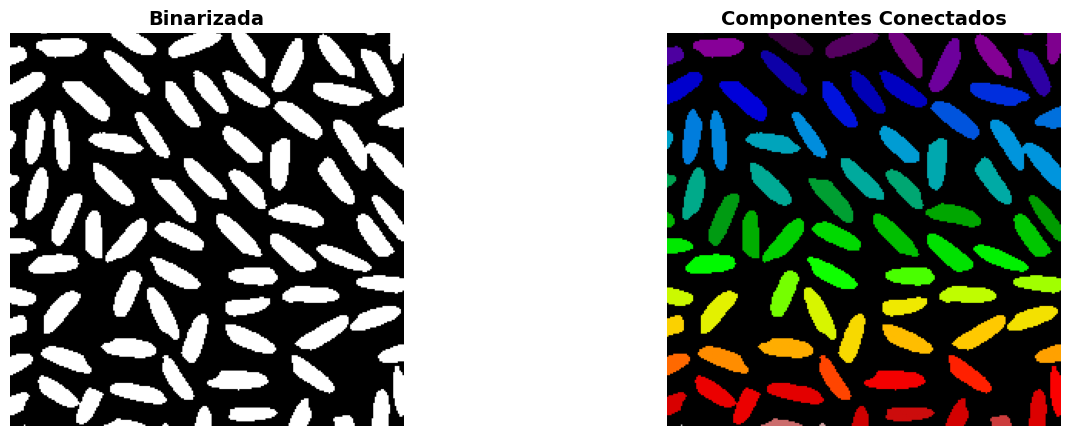

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(img_binarizada,cmap='gray')
plt.axis('off')
plt.title('Binarizada',fontsize=14, fontweight='bold')
plt.subplot(1,2,2)
plt.imshow(labels,cmap='nipy_spectral')
plt.axis('off')
plt.title('Componentes Conectados',fontsize=14, fontweight='bold')
plt.tight_layout(pad=3)
plt.show()


A implementação utilizando a função para encontrar componentes conectados se mostrou eficaz, como demonstrado na figura anterior, exibindo que todos os grãos presentes na imagem binarizada também aparecem na imagem resultante do método. Temos ainda que, no canto superior direito, dois grãos foram considerados um único elemento devido à proximidade entre eles na imagem. A partir do resultado obtido na aplicação da função para encontrar elementos conectados para se desenhar o contorno basicamente foram utilizada as coordenadas dos elementos conectados e as comparou com uma lista contendo as coordenadas pertencentes às bordas da imagem, obtendo assim o resultado exibido na próxima imagem.

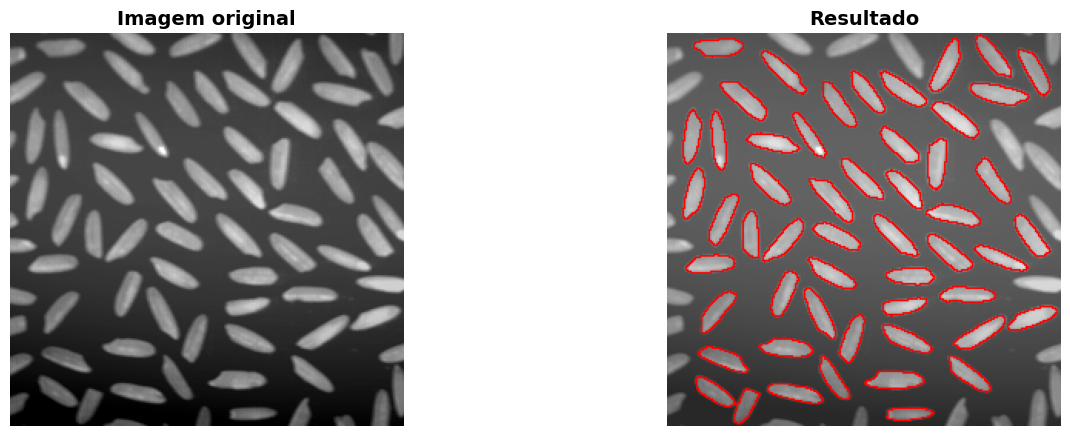

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(img_4,cmap='gray')
plt.axis('off')
plt.title('Imagem original',fontsize=14, fontweight='bold')
plt.subplot(1,2,2)
plt.imshow(resultado_final,cmap='gray')
plt.axis('off')
plt.title('Resultado',fontsize=14, fontweight='bold')
plt.tight_layout(pad=3)
plt.show()

Como pode ser observado, o método implementado se mostrou eficaz em encontrar os grãos de arroz, sendo capaz de identificar todos os grãos que não tocam nas bordas da imagem, apresentando um único grão que foi considerado um componente conectado pelo método e ficou sem receber a coloração vermelha nas bordas.

5) -  Using the Hough transform, find the white lines at the road boundaries in the image road.png. Discuss your solution.

Para a obtenção do resultado solicitado no enunciado, temos que, inicialmente, a imagem foi segmentada no espaço de cores HSI para se eliminar o máximo possível de detalhes que poderiam atrapalhar o método ao utilizar a transformada de Hough. Como exercício tem por objetivo encontrar as duas faixas laterais brancas no chão, essencialmente podemos eliminar as árvores e a faixa amarela central da imagem. Para isso, foi utilizado um método similar ao da questão 2 do trabalho, criando uma máscara com foco em eliminar todos os elementos com cores diferentes dos tons de branco presentes na imagem.

A imagem com essa primeira etapa de segmentação então foi binarizada utilizando o método de Otsu. A imagem obtida após essa etapa foi submetida ao método da transformada de Hough para encontrar as faixas, a partir de um sistema de votação, onde cada pixel branco contribui para um "acumulador" no espaço de parâmetros (rho, theta). Os picos de votação neste acumulador revelam os parâmetros das retas mais proeminentes, que são desenhadas de volta sobre a imagem original para a visualização do resultado final.


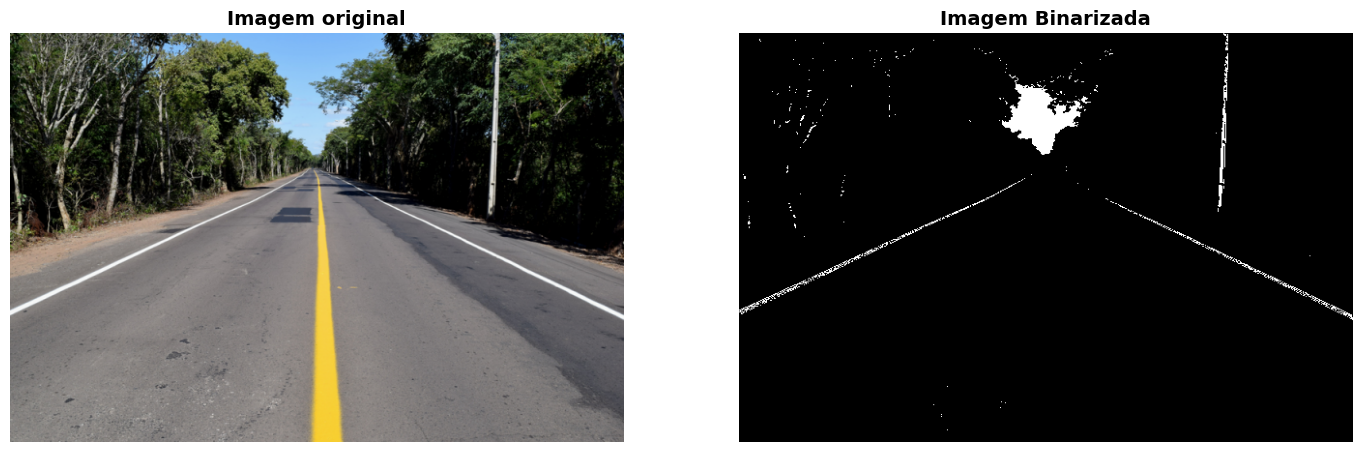

In [ ]:
#Calcula o histograma da imagem:
def calcula_histograma (image):
# Cria vetor para armazenar os niveis de cinza
  histogram = [0] *256
  for i in range (image.shape[0]):
    for j in range (image.shape[1]):
      intensidade = int(image[i,j])
      histogram [intensidade] = histogram[intensidade] + 1
  return np.array(histogram)

def transforma_rgb_hsi(img):
  # Normaliza os valores para a faixa [0,1]
    img_rgb = img.astype(float) / 255.0

  # Separa os canais de cores
    img_red   = img_rgb [:, :, 0]
    img_green = img_rgb [:, :, 1]
    img_blue  = img_rgb[:, :, 2]

    # Inicialização das matrizes
    altura, largura = img.shape[0], img.shape[1]
    H = np.zeros((altura, largura))
    S = np.zeros((altura, largura))
    I = np.zeros((altura, largura))
    img_hsv = np.zeros((altura, largura, 3))

    # Conversão pixel a pixel de RGB para HSI
    epsilon = 1e-10 #Adicionei esse valor da divisao para evitar dividir por zero.
    for linha in range(altura):
        for coluna in range(largura):
            R = img_red[linha, coluna]
            G = img_green[linha, coluna]
            B = img_blue[linha, coluna]

            num = 0.5 * ((R - G) + (R - B))
            den = np.sqrt((R - G)**2 + (R - B) * (G - B)) + 1e-10 + epsilon
            theta = np.arccos(num / den)

            # Calculo do matiz (H)
            if B <= G:
                H[linha, coluna] = theta
            else:
                H[linha, coluna] = 2 * np.pi - theta

            # Calculo da intensidade (I)
            I[linha, coluna] = (R + G + B) / 3
            # Calculo da saturação (S)
            S[linha, coluna] = 1 - (3 * min(R, G, B)) / (R + G + B + epsilon)
    #Mescla os canais para gerar a imagem final
    img_hsi = np.stack((H, S, I), axis=-1)
    return img_hsi

def segmenta_por_cores (img):
  # Converte a imagem para HSI
  img_hsi = transforma_rgb_hsi(img)
  # inicializacao de varizeis utilizadas
  altura, largura = img.shape[0], img.shape[1]
  S = np.zeros((altura, largura))
  I = np.zeros((altura, largura))
  H = np.zeros((altura, largura))
  #Cria imagens vazias para a mascara e para a imagem segmentada
  mask = np.zeros((altura, largura))
  img_segmentada = np.zeros_like(img)
  #Separa a imagem HSI em tres canais de cores diferentes
  H,S,I = img_hsi[:,:,0], img_hsi[:,:,1], img_hsi[:,:,2]
  H = np.degrees(H)
  #busca tons de brancos considerando o hsi:
  limiar_saturacao_max = 0.25
  limiar_intensidade_min = 0.7
  #remove tambem o ceu da imagem:
  limiar_h_azul_min = 150
  limiar_h_azul_max = 200
  # Cria uma mascara pegar brancos e eliminar o azul do ceu
  mask[(S < limiar_saturacao_max) & (I > limiar_intensidade_min)] = 255
  mask[(H > limiar_h_azul_min) & (H < limiar_h_azul_max)] = 0

  # Aplica mascara na imagem original
  for i in range (altura):
    for j in range (largura):
      if mask[i,j] == 0 :
        img_segmentada[i,j] = 0
      else:
        img_segmentada[i,j] = img[i][j]
  return img_segmentada




def binariza_com_otsu(img):

    altura, largura = img.shape
    hist = calcula_histograma(img)

    # probabilidade de cada intensidade
    pi = hist / (altura * largura)

    p1 = np.zeros(256)  # probabilidade acumulada
    m = np.zeros(256)  # media acumulada
    vr = np.zeros(256) # variancia entre classes

    #calculo da media global
    mg = np.sum(np.arange(256) * pi)
    maior_var = 0
    maior_limiar = 0

    # Busca o limiar otimo
    for k in range(256):
        p1[k] = np.sum(pi[:k])
        m[k] = np.sum(np.arange(k) * pi[:k])

        if p1[k] != 0 and p1[k] != 1:
            vr[k] = ((mg * p1[k] - m[k]) ** 2) / (p1[k] * (1 - p1[k]))
            if vr[k] > maior_var:
                maior_var = vr[k]
                maior_limiar = k

    # Cria imagem binarizada com o limiar encontrado
    img_binarizada = np.zeros_like(img)
    img_binarizada[img > maior_limiar] = 255

    return img_binarizada


def hough_transform(img, threshold):
    altura, largura = img.shape
    thetas = np.arange(-90, 90)
    rhos = np.arange(-int(np.sqrt(2) * max(altura, largura)),
                     int(np.sqrt(2) * max(altura, largura)))
    acumulador = np.zeros((len(thetas), len(rhos)), dtype=np.uint64)

    offset_rho = len(rhos) // 2

    # Preenche espaço de Hough
    for y in range(altura):
        for x in range(largura):
            if img[y, x] == 255:  # pixel pertence a borda
                for t_idx, theta in enumerate(thetas):
                    rho_val = int(x * np.cos(np.radians(theta)) + y * np.sin(np.radians(theta)))
                    acumulador[t_idx, rho_val + offset_rho] += 1

    # Seleciona linhas que ultrapassam o threshold
    linhas = []
    for t_idx in range(len(thetas)):
        for r_idx in range(len(rhos)):
            if acumulador[t_idx, r_idx] > threshold:
                rho = rhos[r_idx]
                theta = thetas[t_idx]
                linhas.append((rho, theta))
    return linhas


def desenha_linhas_hough(img_colorida, linhas):
    img_com_linhas = img_colorida.copy()
    for rho, theta_graus in linhas:
        theta_rad = np.deg2rad(theta_graus)
        a = np.cos(theta_rad)
        b = np.sin(theta_rad)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(img_com_linhas, pt1, pt2, (225, 0, 0), 3)
    return img_com_linhas




#Testando as funcoes implementadas.
img_5 = cv2.imread('road.png', cv2.IMREAD_COLOR)
img_5 = cv2.cvtColor(img_5, cv2.COLOR_BGR2RGB)
mask_img = segmenta_por_cores(img_5)
img_binarizada = binariza_com_otsu(cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY))
result = hough_transform(img_binarizada, 150)
img_final = desenha_linhas_hough(img_5, result)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(img_5,cmap='gray')
plt.axis('off')
plt.title('Imagem original',fontsize=14, fontweight='bold')
plt.subplot(1,2,2)
plt.imshow(img_binarizada,cmap='gray')
plt.axis('off')
plt.title('Imagem Binarizada' ,fontsize=14, fontweight='bold')
plt.tight_layout(pad=3)
plt.show()



Como podemos perceber, o método proposto foi bastante eficaz na binarização, pois reduziu significativamente a quantidade de elementos que precisam ser processados na transformada de Hough. Como utilizamos uma estratégia baseada em limiares, o céu ao fundo da imagem apresenta tons de branco no espaço HSI, o que faz com que alguns pixels não sejam completamente eliminados.

Depois de binarizar a imagem, ela é submetida ao método da transformada de Hough para identificar as faixas laterais da pista.

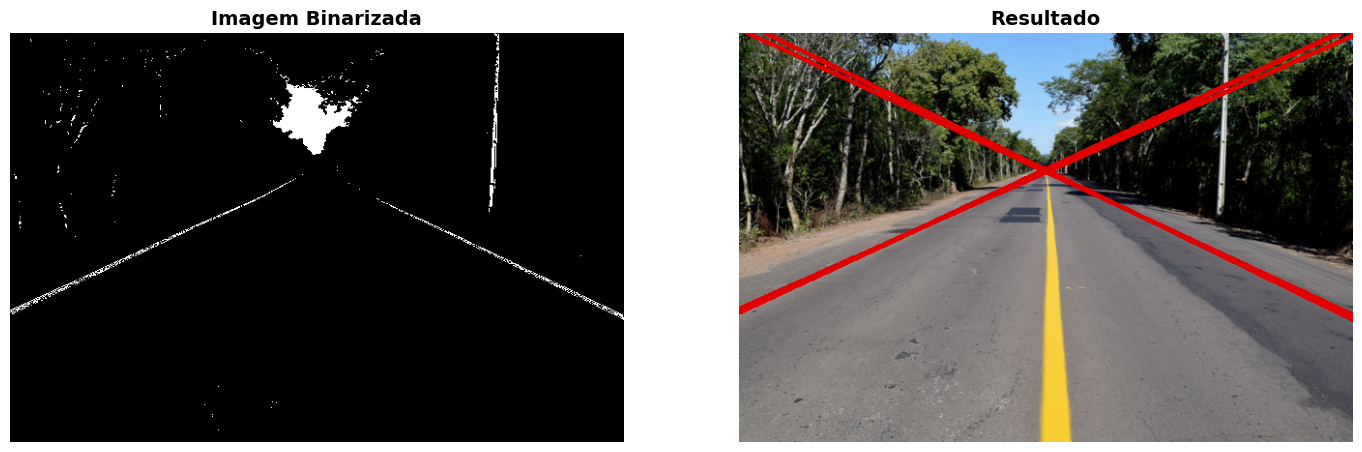

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(img_binarizada,cmap='gray')
plt.axis('off')
plt.title('Imagem Binarizada' ,fontsize=14, fontweight='bold')
plt.subplot(1,2,2)
plt.imshow(img_final,cmap='gray')
plt.axis('off')
plt.title('Resultado',fontsize=14, fontweight='bold')
plt.tight_layout(pad=3)
plt.show()

Temos que o resultado obtido demonstra que a função implementada para transformada de Hough se mostrou funcional, sendo eficaz em encontrar as linhas laterais brancas do asfalto, ainda que a imagem binária utilizada não estivesse totalmente limpa. O sistema de votação utilizado pela transformada de Hough se mostrou eficaz ignorando completamente a mancha referente ao céu e favorecendo os pixels alinhados (colineares), com isso temos que são desenhadas 4 linhas (contornos da extremidades das duas faixas) que seguem perfeitamente a localização das mesmas na imagem e se encontram em um x, já que continuam formando a linha reta mesmo após o término das faixas na imagem.

6)- Reproduce example 10.20 from the textbook. Comment on the results.

Para se reproduzir o exemplo descrito no livro, inicialmente se utilizou a função calcula_histograma() para se obter o histograma da imagem. Para demonstrar os efeitos obtidos para os diferentes métodos de binarização, inicialmente se desensolveu as funções para se realizar a binarização usando algoritmo iterativo que utiliza o principio de busca do melhor limiar para binarizar a imagem, para isso o mesmo se inicia com uma estimativa da média da intensidade da imagem e faz o refinamento até que valor do limiar se encontre estabilizado, isso encerra a busca indicando que já se encontrou um limiar ótimo para o processo de binarização.

Um segundo método testado é a binarização utilizando Otsu que foi implementado na função binariza_com_otsu (), que faz a binarização seguindo o algoritmo clássico do metódo.

Por fim para solucionar os problemas encontrado nos resultados obtidos pelos dois metódos das funções anteriores, temos que foi feito o desenvolvimento de uma função para aplicar o metódo de Otsu utilizando subamostras da imagem original para isto a imagem principal foi dividida em uma grade de várias sub-imagens menores (2x3). Em seguida, aplica-se o método de Otsu a cada uma dessas sub-imagens de forma independente. No final do processo, junta-se todos os resultados, criando uma imagem binarizada que se adapta às diferentes condições de iluminação em cada parte da imagem original.


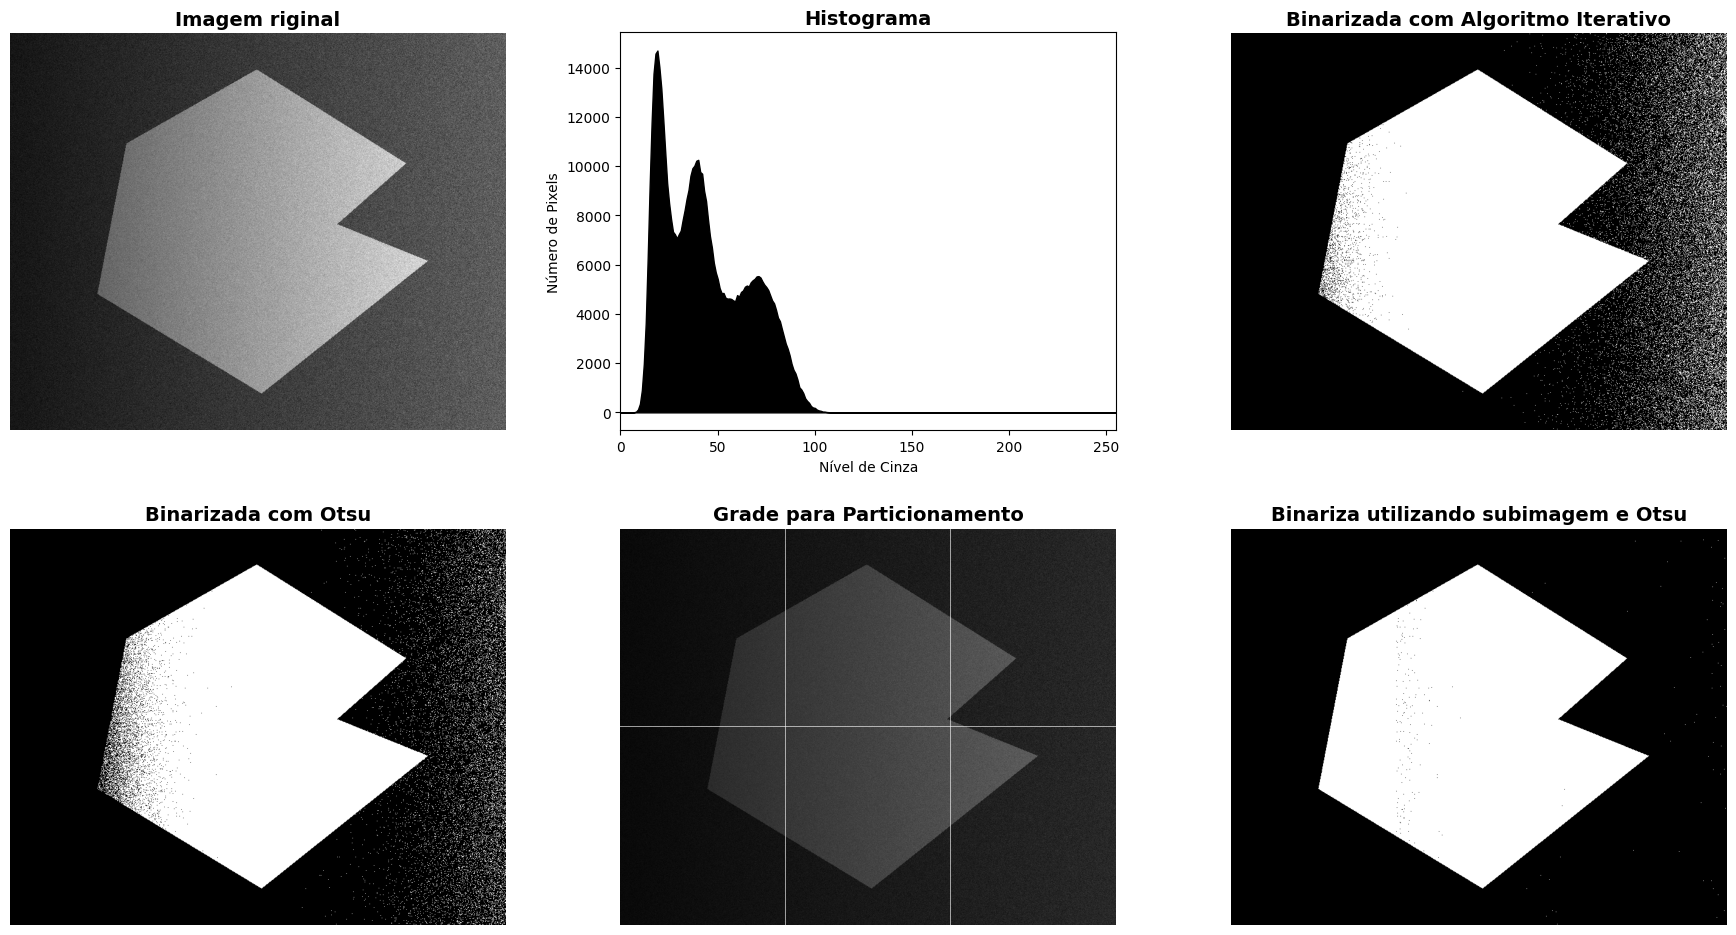

In [ ]:
#Calcula o histograma da imagem:
def calcula_histograma (image):
  histogram = [0] *256
  for i in range (image.shape[0]):
    for j in range (image.shape[1]):
      intensidade = int(image[i,j])
      histogram [intensidade] = histogram[intensidade] + 1
  return np.array(histogram)

def executa_binarizacao(img, t):
  #Extraindo as dimensoes da imagem e criando uma nova imagem vazia para receber o resultado.
  altura, largura = img.shape
  img_binarizada = np.zeros_like(img)
  #Percorre a imagem aplicando o processo de binarizacao
  for i in range (altura):
    for j in range (largura):
      #se o pixel for maior que o limiar t o valor assumido e preto
      if img[i,j] >= t :
        img_binarizada [i,j] = 255
      #se for menor assume o novo pixel e branco
      else:
        img_binarizada [i,j] = 0

  return img_binarizada

def aplica_binarizacao_limiar_iterativo (img, param_T = 1.0):
  #inicilizando T com um valor inicial:
  T = np.mean(img)

  #Inciliza o processo de busca iterativa pelo melhor limiar:
  while True:

    T_utilizado = T

    #Dividindo a imagem em dois grupos G1 e G2 considerando
    #o valor de T,usando exatamente a metade:
    g1 = img[img <= T]
    g2 = img[img > T]

    #Calculo dos valores da intesidade média:
    media1 = np.mean(g1) if len(g1) > 0 else 0
    media2 = np.mean(g2) if len(g2)> 0 else 0

    #Calculando o valor do novo limiar:
    T = 0.5 *(media1 + media2)

    # Encerra a busca se o valor de T for menor que o passado
    #por parametro na função.
    if abs(T - T_utilizado) < param_T:
      break

    best_limiar = int(round(T))
  img_binarizada = executa_binarizacao(img, best_limiar)

  return img_binarizada

def aplica_otsu_subimagem (img):

  altura, largura = img.shape
  img_com_grade = img.copy()
  img_binarizada_final = np.zeros_like(img)
  #Divisao da imagem considerando a altura total:
  meia_altura = altura // 2

  #Divisao da imagem criando tres colunas diferentes:
  pontos_linha = [0, altura // 2, altura]
  pontos_coluna = [0, largura // 3, 2 * (largura // 3), largura]

  #desenhado a grade:
  img_com_grade[pontos_linha[1],:] = 255
  img_com_grade[:, pontos_coluna[1]] = 255
  img_com_grade[:, pontos_coluna[2]] = 255

  # Aplica Otsu em cada subimagem gerada pela grade
  for i in range (2):
    for j in range (3):
      #Obtendos as coordenadas da grade da imagem
      y_inicio, y_fim = pontos_linha[i], pontos_linha[i+1]
      x_inicio, x_fim = pontos_coluna[j], pontos_coluna[j+1]
      # Extrai a subimagem
      sub_imagem = img[y_inicio:y_fim, x_inicio:x_fim]
      # Aplica Otsu na subimagem
      # Coloca a subimagem binarizada no resultado final
      sub_imagem_binarizada = binariza_com_otsu(sub_imagem)
      img_binarizada_final[y_inicio:y_fim, x_inicio:x_fim] = sub_imagem_binarizada

  return img_com_grade, img_binarizada_final


#Testando as imagens implementadas:
img_6 = cv2.imread('Fig1046(a).tif', cv2.IMREAD_GRAYSCALE)
histograma = calcula_histograma(img_6)
img_binarizada_iterativa = aplica_binarizacao_limiar_iterativo(img_6, 1)
img_binarizada = binariza_com_otsu(img_6)
img_grade, binariza_subimg_otsu = aplica_otsu_subimagem(img_6)
niveis_de_cinza = np.arange(256)

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(img_6, cmap='gray')
plt.title('Imagem riginal',fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(2, 3, 2)
niveis_de_cinza = np.arange(256)
plt.fill_between(niveis_de_cinza, histograma, color='black')
plt.title('Histograma',fontsize=14, fontweight='bold')
plt.xlabel('Nível de Cinza')
plt.ylabel('Número de Pixels')
plt.xlim([0, 255])

plt.subplot(2, 3, 3)
plt.imshow(img_binarizada_iterativa, cmap='gray')
plt.title('Binarizada com Algoritmo Iterativo', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(img_binarizada, cmap='gray')
plt.title('Binarizada com Otsu', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(img_grade, cmap='gray')
plt.title('Grade para Particionamento', fontsize=14, fontweight='bold')
plt.axis('off')


plt.subplot(2, 3, 6)
plt.imshow(binariza_subimg_otsu, cmap='gray')
plt.title('Binariza utilizando subimagem e Otsu', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout(pad=3)
plt.show()




Os resultados obtidos para a resolução do exercício foram muito similares aos exibidos no livro texto, como demonstrado, a imagem originalmente é um polígono com uma iluminação que varia ao decorrer da imagem, pelo histograma pode se visualizar  que os tons presentes variam entre os níveis 10 a 100, ao se aplicar os métodos de limiaração com algoritmo iterativo e com Otsu os resultados obtidos não foram bons e muitos similares, o que pode ser justificado pelo fato de que um limiar único é incapaz de compensar o gradiente de luminosidade presente na imagem, o que gera o ruído e a falha na separação ente objeto e fundo da imagem, especialmente em áreas mais escuras.

O método que corrige o problema é justamente o processo de binarização utilizando subamostras da imagem, para o funcionamento do metódo temos que a imagem foi particionada seguindo o que foi demonstrado na quinta imagem, onde cada subamostra então é binarizada utilizando o metódo de Otsu.

O processo então gerou uma imagem binarizada bem mais limpa e clara, possuindo uma separação nitida do objeto e do fundo com o mínimo de ruído, que só é possível de ser obtido devido ao particionamento da imagem permitir calcular um limiar otimizado para cada pedaço da imagem analisada, resolvendo assim o problema existente para iluminação da imagem, evidenciando que o particionamento da imagem nesse caso é um metódo eficaz.




##Theoretical questions:

1) Show with examples why the duality between erosion and dilation, shown in Chapter 9, is true.

A erosão e dilatação são operações morfológicas básicas que possuem por característica funcionarem de forma oposta, visto que enquanto o processo de erosão consiste em uma operação de afinamento (ou redução) dos pixels existentes na imagem binarizada, a operação de dilatação faz com que ocorra um aumento (ou engrossamento) dos objetos presentes em uma imagem binária. No que consiste a dualidade, temos que ambas as operações são duais em relação à complementação e reflexão de conjuntos, como definido na Unidade 9 do livro: \\
$$(A \ominus B)^C = A^C  \oplus \hat{B}$$
$$e$$
$$(A \oplus B)^C = A^C  \ominus \hat{B}$$

onde:

  * A é o conjunto original (imagem binária, por exemplo),

  * B é o elemento estruturante,

  * $\hat{B}$ é o elemento estruturante refletido (espelhado),

  * $\ominus$ representa a erosão,

  * $\oplus$ representa a dilatação,

  * C indica o complemento do conjunto.


A partir das equações, podemos observar que a erosão de A por B é equivalente ao complemento da dilatação de $A^C$ por $\hat{B}$. O mesmo raciocínio vale de forma inversa, essa propriedade é particularmente útil quando o elemento estruturante é simétrico em relação à origem, pois permite obter a erosão de uma imagem por B a partir do processo de dilatação do fundo (dilatação de $A^C$) com o mesmo elemento estruturante e complementando o resultado final.

Tomando como exemplo um conjunto A em uma linha e um elemento estruturante B, tais que A={1,2,3,4,5} e B={0,1}, com um U={1,2,3,4,5,6,7}:



1.   Calculando o complemento:
$$A^C=\frac{U}{A}={6,7}$$

2.   Calculando a erosão:

Para B={0,1}, temos que a operação de erosão cobre os pixels da imagem tal que {x,x+1}, logo considera-se o deslocamento x , analisando os elementos presentes em A:

* x=1: {1,2} ⊆A {1,2} ⊆A ? Como 1 e 2 estão em A, logo é adicionado ao resultado da erosão.

* x=2: {2,3} ⊆A {2,3} ⊆A ? Como 2 e 3 estão em A, logo é adicionado ao resultado da erosão.

* x=3: {3,4} ⊆A {3,4} ⊆A ? Como 3 e 4 estão em A, logo é adicionado ao resultado da erosão.

* x=4: {4,5} ⊆A {4,5} ⊆A ? Como 4 e 5 estão em A, logo é adicionado ao resultado da erosão.

* x=5: {5,6} ⊆A {5,6} ⊆A ? Como 6 não está A, 5 é ignorado.

* x=6: {6,7} Como 6 e 7 não estão em A, 6 é ignorado.

 Logo o resultado da erosão será:

$$(A \ominus B) = \{1, 2, 3, 4\}$$

3. Refletindo o elemento B:

$$ B= \{1,0\} \Rightarrow \hat{B} = \{-1,0\}$$

4. Fazendo a dilatação do complemento:

$$
A^c \oplus \hat{B} = \{x \in U : (x + \hat{B}) \cap A^c \neq \emptyset \}
$$

Considerando o que foi obtido na reflexão, temos que o deslocamento do conjunto será { x - 1, x }, testando com os mesmo valores de U = {1,2,3,4,5,6,7}:

*  $x=1: \{0,1\} \cap A^c = \emptyset$, não está contido em U e 1 não esta em $A^C$, ignorado.
*  $x=2: \{1,2\} \cap A^c = \emptyset$, valores não contidos em $A^C$, ignorado.
*  $x=3: \{2,3\} \cap A^c = \emptyset$, valores não contidos em $A^C$, ignorado.
*  $x=4: \{3,4\} \cap A^c = \emptyset$, valores não contidos em $A^C$, ignorado.
*  $x=5: \{4,5\} \cap A^c = \emptyset$, valores não contidos em $A^C$, ignorado.
*  $x=6: \{5,6\} \cap A^c = \{6\} \neq \emptyset$, inclui o valor 6.
*  $x=7: \{6,7\} \cap A^c = \{6,7\} \neq \emptyset$, inclui o valor 7.

Logo temos  que o resultado da diatação será:
$$A^c \oplus \hat{B} = \{6,7\}$$

5. Fazendo o complemento do resultado da erosão:

$$(A \ominus B)^c = U \setminus (A \ominus B) = \{1, 2, 3, 4, 5, 6, 7\} \setminus \{1, 2, 3, 4\} = \{5, 6, 7\}$$

6. Comparando os resultado obtidos temos:

$$(A \ominus B)^c = \{5, 6, 7\}, \quad A^c \oplus \hat{B} = \{6, 7\}$$


Nota-se que os conjuntos não são iguais. Isso ocorre porque a propriedade da dualidade entre erosão e dilatação se manifesta plenamente quando se considera universos grandes (ou infinitos) e elementos estruturantes simétricos. Em universos pequenos, como neste exemplo, efeitos de borda fazem com que a igualdade não seja exata.


2)- Try to define in your own words what texture is in an image. Why is it important in image segmentation?

Textura em imagens está diretamente ligada à aparência da superfície, permitindo descrevê-la a partir de medidas de propriedades como suavidade, rugosidade e regularidade, sendo tais características perceptíveis por meio da visão. Quando se processam imagens, existem três abordagens possíveis para descrever a textura de uma determinada região: a abordagem estatística, a abordagem estrutural e a abordagem espectral.
Na abordagem espectral, é possível obter a periodicidade global a partir dos picos de alta energia presentes no espectro, utilizando como base as propriedades da transformada de Fourier. Já as abordagens estatísticas permitem produzir caracterizações das texturas, como suave, rugosa,  granulada e etc.

Por fim, temos as abordagens baseadas em técnicas estruturais que permitem descrever texturas formadas por linhas paralelas espaçadas regularmente, por meio do agrupamento dos elementos fundamentais da imagem.

Devido ao fato de permitir obter tais padrões e características, a textura se torna um dos parâmetros mais importantes para a segmentação de imagens. Visto que permite diferenciar materiais, reconhecer objetos e regiões,  mesmo que não exista a presença de bordas bem definidas ou grandes diferenças entre as cores presentes na imagem.

3)- Summarize the co-occurrence matrix method (Section 11.3.3).

A matriz de coocorrência de níveis de cinza é um método estatístico útil para se executar a análise de uma região pertencente a imagem. Para fazer isso, temos que são quantificado as relações espaciais presentes entre os pixels presentes na imagem analisando a frequência com a qual os diferentes níveis de intensidade ocorrem a cada disposição espacial.

Para se construir a matriz de coocorrência (G), temos que todo o processo é baseado em um operador de posição (Q), que irá definir a relação espacial entre cada par de pixels presentes na imagem, a partir disso temos que :

* O elemento $g_{i,j}$ da matriz representa o número de vezes que uma par de pixels com intensidade $z_i$ e $z_j$ ocorre na imagem na posição definida por Q.

* O tamanho da matriz é determinado pelo número de níveis de intensidade (L) presentes na imagem.

* Nos casos de imagens de 8 bits (256 níveis) as intensidades presentes na imagens são quantizadas em menos níveis.

O processo de análise de uma matriz coocorrência é feito dividindo cada elemento presente pela soma total de todos os seus elementos, fazendo com que a matriz se transforme em uma matriz de probabilidade $p_{i,j}$, essa matriz normalizada então permite o cálculo de um conjunto de descritores para fazer a caracterização da textura presente na imagem, dos quais podemos citar:

* Probabilidade máxima: Mede a resposta mais forte na matriz G.

* Correlação: Mede o quão correlacionado um pixel está com seu vizinho, indicando a presença de padrões lineares nas intensidades.

* Contraste: Mede o contraste de intensidade local entre um pixel e seu vizinho em toda a imagem.

* Uniformidade (Energia): É uma medida de uniformidade textural.

* Homogeneidade: Mede a proximidade da distribuição dos elementos de G à sua diagonal principal.

* Entropia: Mede a aleatoriedade dos elementos de G, que por sua vez reflete a aleatoriedade da textura na imagem.

A partir da análise das sequências de matrizes de coocorrência que surgem a partir do aumento da distância no operador (Q), temos que é possível visualizar  possíveis padrões presentes nas texturas periódicas, a partir da observação do comportamento dos descritores existentes.


4) Based on Chapter 11 of the book, mention some characteristics that you could
use to distinguish squares from circles in an image. Consider that both elements
can be subject to translation, scale change and rotation. Explain why the characteristics mentioned would be useful.

Temos quatro características que podem ser utilizadas para identificar círculos e quadrados  em imagens, desconsiderando as operações descritas:  razão de circularidade,  assinaturas,transformada de eixo médio e os momentos invariantes de Hu.

 * Transformada de eixo médio (esqueleto): consiste em representar uma região plana a partir da redução de sua forma até uma estrutura de grafo, logo considerando o resultado obtido quando utilizado em círculos e em quadrados a topologia obtida para cada caso será diferente.  O processo de redução consiste em obter um conjunto de pontos equidistantes de duas ou mais partes de suas fronteira, temos  que para um círculo gera um único ponto central, enquanto ao se aplicar a técnica em um quadrado, obtem se um conjunto de quatro segmentos de linha que se encontram no centro e se estendem até o ponto médio de cada lado formando uma cruz. Como o esqueleto é uma propriedade geométrica da forma, ele é invarante  à translanção e à rotação.

 * Circularidade (compacidade) : é um descritor númerico simples,  útil pelo fato de que sua função básica é verificar a similaridade de um forma analisada em comparação ao formato de um círculo, que pode ser observada pela relação a seguir.

 $$R_c = \frac{4*ΠA}{P²}$$

 onde A é área da região e P é o perímetro.

 Quando o elemento analisado é um círculo, essa equação retorna como resultado $R_c = 1$. Já um quadrado, o valor retornado será $R_c =Π/4$ (aproximadamente 0,785). Por se tratar de uma medida adimensional, operações de mudança de escala e rotação não influenciam no resultado. O mesmo ocorre para a translação, já que área e o perímetro não mudam com a sua posição.

* Momentos invariantes de Hu : funcionam como uma impressão digital da forma analisada, visto que avaliam um conjunto de sete valores númericos referentes aos momentos levando em consideração os pontos centrais normalizados da imagem analisada. Cada distribuição de pixels presentes em uma imagem é caracterizada de maneira distinta. Considerando os formatos  do círculo e do quadrado, o resultado obtido pelo metódo produz um conjunto de valores de momentos distintos. Dessa forma, é possível treinar um modelo para fazer a classificação entre as duas formas por exemplo. Em relação as transformações, temos que os momentos  Hu são invariantes à rotação, translação e mudança de escala.

* Momentos estátisticos (Assinatura): consistem em obter um representação 1D de uma fronteira 2D. Para duas formas geométricas, podem ser  obtidas assinaturas gráficas distintas, a partir da plotagem da distância entre o  centroíde da forma até a sua fronteira em função do angulo (r(Θ)).
Considerando um forma circular temos que a distância do centroíde à fronteira é igual ao raio (constante), logo a assinatura r(Θ) será uma linha reta e horizontal. Para um quadrado temos que a distância do centroíde à fronteira irá variar, sendo mínima no ponto médio de um lado e máxima em um vértice, resultando em uma assinatura periódica e ondulada com quadro picos e vales.
Temos que os momentos estátisticos não sofrem influência da translação, quanto a rotação temos a transformação não gera nenhum efeito quando é escolhido um ponto de partida considerando como ponto de fronteira mais distante do centroíde e por fim para transformações de escala temos que efeito pode ser anulado a partir da normalização da amplitude da assinatura.





